In [9]:
%pip install pyspark prophet matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, year, month
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [11]:
from pyspark.sql import SparkSession

# Inicializar SparkSession
spark = SparkSession.builder.appName("AnaliseDengue").getOrCreate()

# Lista com os caminhos dos arquivos CSV
arquivos = [
    "../data/DENGBR23.csv",
    "../data/DENGBR24.csv",
    "../data/DENGBR25.csv"
]

# Ler todos os arquivos CSV e combinar em um único DataFrame do Spark
df = spark.read.option("header", True).option("inferSchema", True).csv(arquivos)

# Limpeza e filtragem de dados
df_clean = df.dropna(subset=["ID_MUNICIP", "DT_NOTIFIC", "CS_SEXO", "NU_IDADE_N"])
df_clean = df_clean.withColumn("data_notificacao", to_date(col("DT_NOTIFIC"), "dd/MM/yyyy"))
df_filtrado = df_clean.filter(col("CLASSI_FIN") == 10)

# Converter para pandas
pdf_filtrado = df_filtrado.limit(1000).toPandas()

# Exportar para CSV
pdf_filtrado.to_csv("dados_filtrados.csv", index=False, encoding="utf-8")

In [12]:
# Extração de ano e mês
df_mes = df_filtrado.withColumn("ANO", year("data_notificacao")) \
                    .withColumn("MES", month("data_notificacao"))

# Agregação mensal
df_agg = df_mes.groupBy("ANO", "MES").count().orderBy("ANO", "MES")

# Conversão para Pandas
pdf = df_agg.toPandas()
pdf['DATA'] = pd.to_datetime(pdf['ANO'].astype(str) + '-' + pdf['MES'].astype(str).str.zfill(2))
pdf = pdf.rename(columns={'count': 'y', 'DATA': 'ds'})[['ds', 'y']]
pdf = pdf.sort_values('ds')

# Já convertido e preparado para o Prophet, por exemplo:
pdf.to_csv("dados_agrupados.csv", index=False, encoding="utf-8")

In [14]:
# Treinamento do modelo Prophet
modelo = Prophet()
modelo.fit(pdf)

# Geração de previsões para 12 meses à frente
future = modelo.make_future_dataframe(periods=12, freq='M')
forecast = modelo.predict(future)

# Exporte o forecast completo para CSV
forecast_future = forecast[forecast['ds'] > pdf['ds'].max()]
forecast_future.to_csv('previsao_futura.csv', index=False, encoding='utf-8')

22:26:31 - cmdstanpy - INFO - Chain [1] start processing
22:26:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Mario\Documents\Gits\projeto-bigdatas2\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


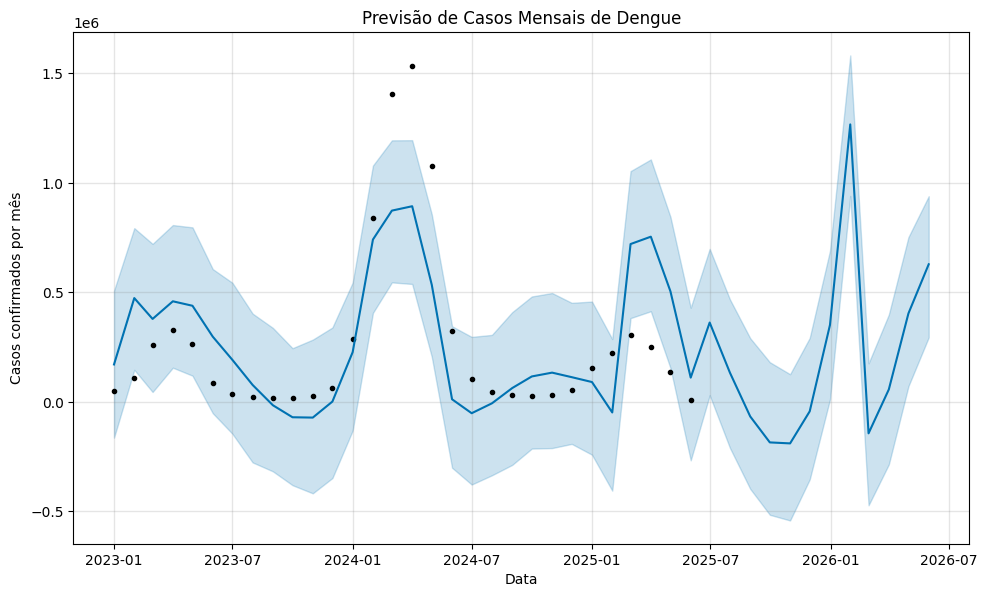

In [15]:
import matplotlib.pyplot as plt

fig = modelo.plot(forecast)
plt.title('Previsão de Casos Mensais de Dengue')
plt.xlabel('Data')
plt.ylabel('Casos confirmados por mês')
plt.grid(True)
plt.show()


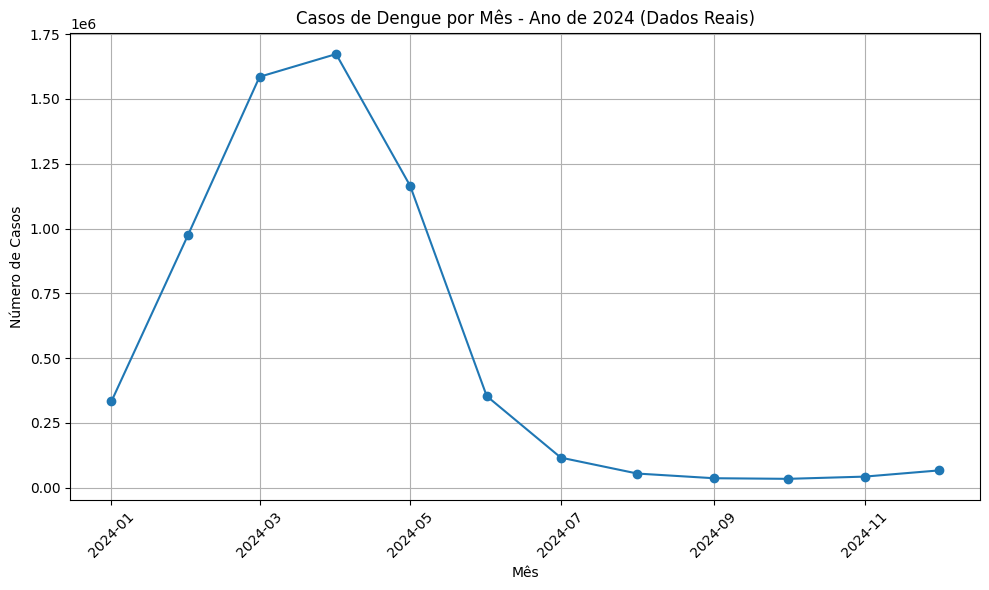

In [16]:

# Filtrar somente o ano de 2024
df_2024 = df.filter(year(col("DT_NOTIFIC")) == 2024)

# Criar colunas de ano e mês
df_2024 = df_2024.withColumn("ANO", year(col("DT_NOTIFIC"))) \
                 .withColumn("MES", month(col("DT_NOTIFIC")))

# Agrupar por mês
df_2024_agg = df_2024.groupBy("ANO", "MES").count().orderBy("MES")

# Converter para Pandas
pdf_2024 = df_2024_agg.toPandas()

# Criar coluna de data
pdf_2024['DATA'] = pd.to_datetime(pdf_2024['ANO'].astype(str) + '-' + pdf_2024['MES'].astype(str), format='%Y-%m')

# Plotar gráfico
plt.figure(figsize=(10,6))
plt.plot(pdf_2024['DATA'], pdf_2024['count'], marker='o', linestyle='-')
plt.title("Casos de Dengue por Mês - Ano de 2024 (Dados Reais)")
plt.xlabel("Mês")
plt.ylabel("Número de Casos")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pdf_2024.to_csv('pdf_2024_exportado.csv', index=False, encoding='utf-8')
